# 2 - Models Training and Evaluation

### Data Importing:

We start with building a spark session since we will be executing this project using Spark

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder \
    .appName("BaseballBatting") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

print("Spark version:", spark.version)


print(spark)

Spark version: 4.0.1


We import the cleaned data that we exported from our EDA jupyter notebook and we read it into a dataframe using Spark

In [2]:
df = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .csv("cleaned_bankruptcy_data")

df.show(5)


+-------+--------+-------+-------+-------+-------+-------+--------+-------+-------+--------+--------+-------+-------+------+-------+-------+------+--------+--------+--------+--------+------+-------+-----+
| Attr24|  Attr13| Attr26| Attr16| Attr12| Attr38| Attr10|  Attr23|  Attr2| Attr25|  Attr31|  Attr19|  Attr5| Attr51|Attr17|  Attr8| Attr46| Attr4|   Attr1|  Attr18|  Attr14|   Attr7|Attr50| Attr45|class|
+-------+--------+-------+-------+-------+-------+-------+--------+-------+-------+--------+--------+-------+-------+------+-------+-------+------+--------+--------+--------+--------+------+-------+-----+
|0.47706|  0.1666|0.60411|0.73378| 0.6598|0.50591|0.50494| 0.11998|0.37951|0.50494| 0.14942| 0.14942| 32.351|0.37854|2.6349| 1.3305| 1.5225|2.0472| 0.20055| 0.24976| 0.24976| 0.24976| 2.042| 1.0097|    0|
|0.15474| 0.15835|0.43992|0.53838| 0.5168|0.49788|0.49788| 0.12304|0.49988|0.39542|   0.152|   0.152| 14.786|0.49988|2.0005|0.99601| 1.1252|1.9447| 0.20912| 0.25834| 0.25834| 0.258

### Data Preparation:

We split the data into training and testing datasets. We allocate 80% of the data for training and 20% of the data for testing.

In [3]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

In [4]:
# We print the count of each target class to as we already know that our data contains imbalance.
train_df.groupBy("class").count().show()

+-----+-----+
|class|count|
+-----+-----+
|    1| 1674|
|    0|33190|
+-----+-----+



### Data Balancing:

As we already see that our training data has imbalance we resample our data to reduced the imbalance, we oversample the minor class to 70% of the majority class.

I have tried with different percentages of resampling, but 70% gave the best results.

In [5]:
from pyspark.sql.functions import col

# Split by class
minor = train_df.filter(col("class") == 1)
major = train_df.filter(col("class") == 0)

# Counts of each class
minor_cnt = minor.count()
major_cnt = major.count()

# Target minority size = 70% of majority
target_minor_cnt = int(0.7 * major_cnt)

# Oversample
minor_oversampled = minor.sample(
    withReplacement=True,
    fraction=target_minor_cnt / minor_cnt,
    seed=42
)

# Final balanced training set
train_df_balanced = major.union(minor_oversampled)

In [6]:
train_df_balanced.groupBy("class").count().show()

+-----+-----+
|class|count|
+-----+-----+
|    0|33190|
|    1|23377|
+-----+-----+



### Data Assembling and Scaling:

In order to feed our data to training models we need to assemble it in Spark, and I want to scale the data using Standard Scaler because it contains numerical features, that would work best if scaled.

In [7]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

feature_cols = [c for c in train_df_balanced.columns if c != "class" and c != "weight"]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_raw"
)

scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withMean=True,
    withStd=True
)

# Assemble
train_assembled = assembler.transform(train_df_balanced)
test_assembled  = assembler.transform(test_df)

# Fit scaler ONLY on training data
scaler_model = scaler.fit(train_assembled)

# Transform both using the SAME scaler
train_vec = scaler_model.transform(train_assembled)
test_vec  = scaler_model.transform(test_assembled)

### Model Training:

I trained five models: Logistic Regression, Decision Tree, Random Forest, Gradient boosting, Neural Network

In [8]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.classification import GBTClassifier, MultilayerPerceptronClassifier

lr = LogisticRegression(
    featuresCol="features",
    labelCol="class",
    maxIter=50
)

dt = DecisionTreeClassifier(
    featuresCol="features",
    labelCol="class",
    maxDepth=6
)

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="class",
    numTrees=100,
    maxDepth=8
)

gbt = GBTClassifier(
    featuresCol="features",
    labelCol="class",
    maxIter=50,
    maxDepth=5
)

num_features = len(feature_cols)
mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="class",
    layers=[num_features, 32, 16, 2],
    maxIter=100,
    seed=42
)


lr_model = lr.fit(train_vec)
dt_model = dt.fit(train_vec)
rf_model = rf.fit(train_vec)
gbt_model = gbt.fit(train_vec)
mlp_model = mlp.fit(train_vec)

### Models Evaluation:

Now we evaluate the models using metrics such as: AUROC, Accuracy, Precision, Recall, F1 Score. We are going to see which models performed best for our data. Afterwards, we will tune the top 3 models using different hyperparameters.

In [9]:
# in this cell we evaluate the models using various metrics
# at the I created the function evaluate_model to print the results nicely
# and plot the confusion matrix

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import builtins
import matplotlib.pyplot as plt
import seaborn as sns

auc_eval = BinaryClassificationEvaluator(
    labelCol="class",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

metrics = {
    "accuracy": MulticlassClassificationEvaluator(
        labelCol="class", predictionCol="prediction", metricName="accuracy"
    ),
    "precision": MulticlassClassificationEvaluator(
        labelCol="class", predictionCol="prediction", metricName="weightedPrecision"
    ),
    "recall": MulticlassClassificationEvaluator(
        labelCol="class", predictionCol="prediction", metricName="weightedRecall"
    ),
    "f1": MulticlassClassificationEvaluator(
        labelCol="class", predictionCol="prediction", metricName="f1"
    )
}


def evaluate_model(pred_df, model_name):
    evaluations = {}
    evaluations["auroc"] = builtins.round(auc_eval.evaluate(pred_df), 4)
    for k, ev in metrics.items():
        evaluations[k] = builtins.round(ev.evaluate(pred_df), 4)
    y_true = pred_df.select("class").toPandas()["class"]
    y_pred = pred_df.select("prediction").toPandas()["prediction"]
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n===== {model_name} =====")

    print("AUROC:", evaluations["auroc"])

    for k, ev in metrics.items():
        print(f"{k.capitalize()}:", builtins.round(ev.evaluate(pred_df), 4))

    plt.figure(figsize=(2, 2))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["0", "1"],
        yticklabels=["0", "1"]
    )
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    return evaluations


===== Logistic Regression =====
AUROC: 0.7291
Accuracy: 0.9161
Precision: 0.9193
Recall: 0.9161
F1: 0.9177


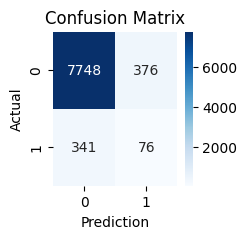


===== Decision Tree =====
AUROC: 0.6106
Accuracy: 0.797
Precision: 0.938
Recall: 0.797
F1: 0.8515


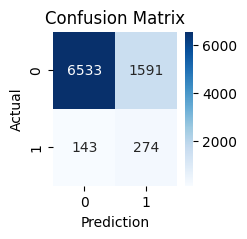


===== Random Forest =====
AUROC: 0.8307
Accuracy: 0.8397
Precision: 0.9388
Recall: 0.8397
F1: 0.8789


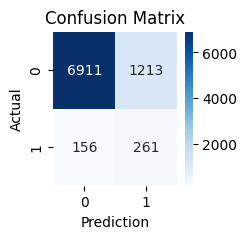


===== Gradient Boosted Trees =====
AUROC: 0.8545
Accuracy: 0.8606
Precision: 0.943
Recall: 0.8606
F1: 0.8928


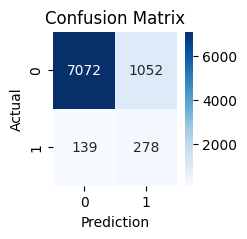


===== Multilayer Perceptron =====
AUROC: 0.7367
Accuracy: 0.7373
Precision: 0.9305
Recall: 0.7373
F1: 0.8112


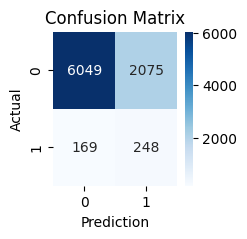

In [10]:
models = {
    "Logistic Regression": {
        "model":lr_model
    },
    "Decision Tree": {
        "model": dt_model
    },
    "Random Forest": {
        "model": rf_model
    },
    "Gradient Boosted Trees": {
        "model": gbt_model
    },
    "Multilayer Perceptron": {
        "model": mlp_model
    }
}

for model in models:
    model_pred = models[model]["model"].transform(test_vec)
    models[model]["evaluation"] = evaluate_model(model_pred, model)


### Visualize the models performance:

Below we visualize the models using the metrics we used to evaluate the models.

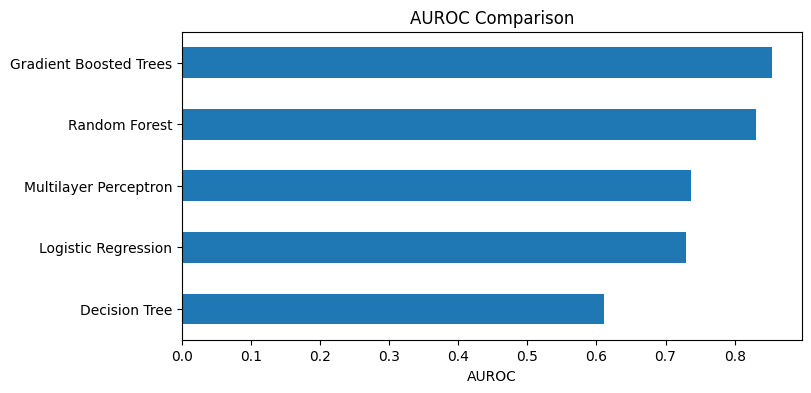

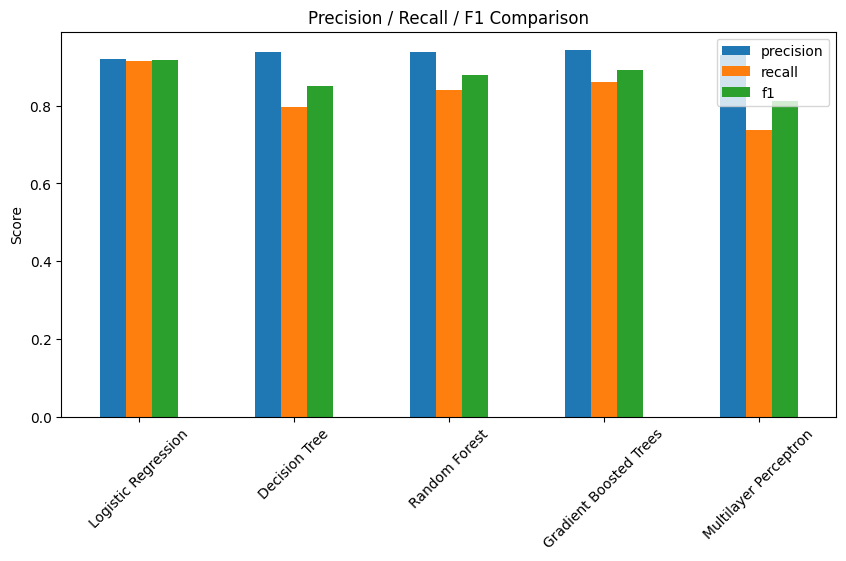

In [11]:
import pandas as pd

metrics_df = pd.DataFrame({
    model: vals["evaluation"]
    for model, vals in models.items()
}).T



metrics_df["auroc"].sort_values().plot(
    kind="barh", figsize=(8, 4), title="AUROC Comparison"
)
plt.xlabel("AUROC")
plt.show()


metrics_df[["precision", "recall", "f1"]].plot(
    kind="bar", figsize=(10, 5)
)
plt.title("Precision / Recall / F1 Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

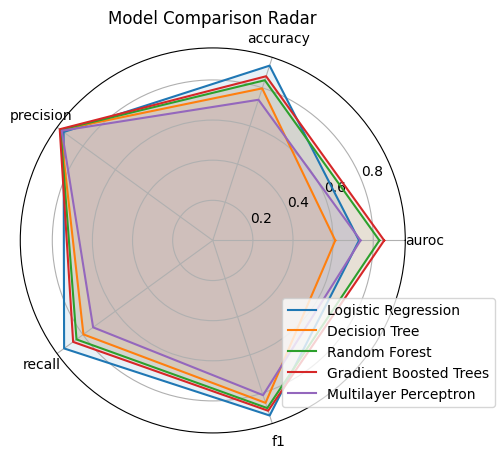

In [12]:
import numpy as np

labels = metrics_df.columns
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))

for model in metrics_df.index:
    values = metrics_df.loc[model].tolist()
    values += values[:1]
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.1)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Model Comparison Radar")
ax.legend(loc="lower right", bbox_to_anchor=(1.25, 0.05))
plt.show()

### Hyperparameter Tuning:

Below I do the hyperparameter tuning for the top 3 models: GBT, RF, LR. We are going to evaluate these models afterwards, and find the best model and best hyperparameters for our prediciton problem

In [13]:
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [14]:
lr = LogisticRegression(featuresCol="features", labelCol="class", maxIter=50)

# Hyperparameter grid
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

cv_lr = CrossValidator(
    estimator=lr,
    estimatorParamMaps=lr_param_grid,
    evaluator=auc_eval,
    numFolds=3,   # 3-fold CV to save time
    parallelism=2
)

cv_lr_model = cv_lr.fit(train_vec)

In [15]:
rf = RandomForestClassifier(featuresCol="features", labelCol="class")

rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 8, 12]) \
    .build()

cv_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=rf_param_grid,
    evaluator=auc_eval,
    numFolds=3,
    parallelism=1
)

cv_rf_model = cv_rf.fit(train_vec)

In [16]:
gbt = GBTClassifier(featuresCol="features", labelCol="class")

gbt_param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.maxIter, [20, 50, 100]) \
    .build()

cv_gbt = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=gbt_param_grid,
    evaluator=auc_eval,
    numFolds=3,
    parallelism=2
)

cv_gbt_model = cv_gbt.fit(train_vec)

Best LogisticRegressionModel: uid=LogisticRegression_6d4d6b0bb55d, numClasses=2, numFeatures=24

===== Logistic Regression =====
AUROC: 0.7227
Accuracy: 0.9479
Precision: 0.9158
Recall: 0.9479
F1: 0.9278


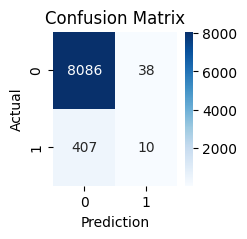

Best RandomForestClassificationModel: uid=RandomForestClassifier_6d38d810d9ae, numTrees=100, numClasses=2, numFeatures=24

===== Random Forest =====
AUROC: 0.8431
Accuracy: 0.9027
Precision: 0.9378
Recall: 0.9027
F1: 0.9176


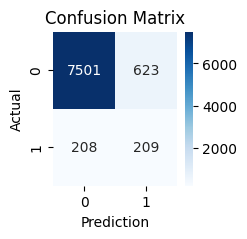

Best GBTClassificationModel: uid = GBTClassifier_97f1ddd0243e, numTrees=100, numClasses=2, numFeatures=24

===== Gradient Boosted Trees =====
AUROC: 0.8483
Accuracy: 0.9169
Precision: 0.9403
Recall: 0.9169
F1: 0.9269


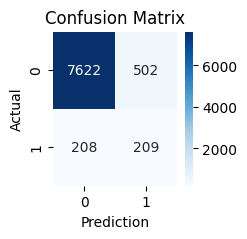

In [17]:
tuned_models = {
    "Logistic Regression": {
        "model": cv_lr_model
    },
    "Random Forest": {
        "model": cv_rf_model
    },
    "Gradient Boosted Trees": {
        "model": cv_gbt_model
    }
}

for model in tuned_models:
    model_pred = tuned_models[model]["model"].transform(test_vec)
    print("Best",tuned_models[model]["model"].bestModel)
    tuned_models[model]["evaluation"] = evaluate_model(model_pred, model)

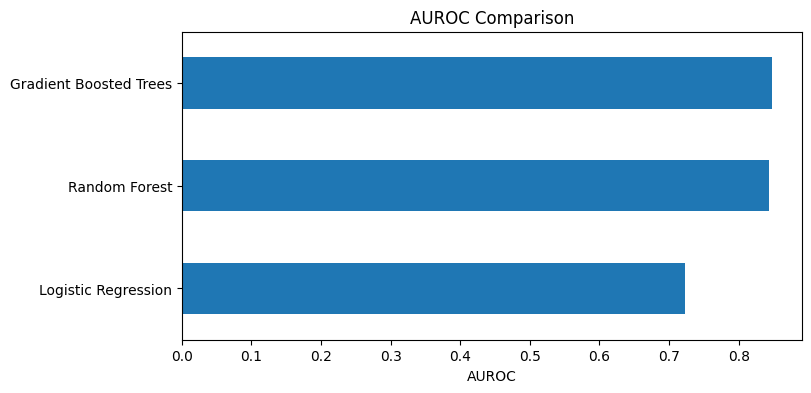

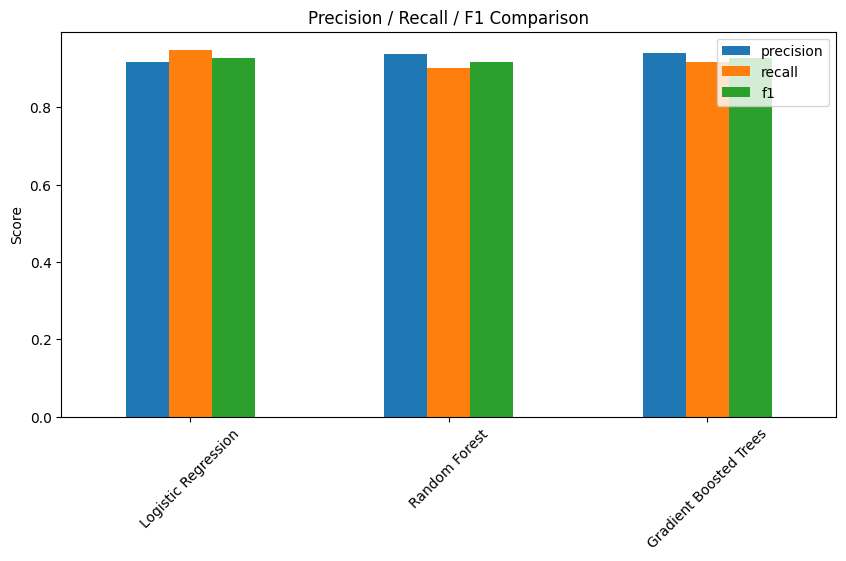

In [18]:
tuned_metrics_df = pd.DataFrame({
    model: vals["evaluation"]
    for model, vals in tuned_models.items()
}).T



tuned_metrics_df["auroc"].sort_values().plot(
    kind="barh", figsize=(8, 4), title="AUROC Comparison"
)
plt.xlabel("AUROC")
plt.show()


tuned_metrics_df[["precision", "recall", "f1"]].plot(
    kind="bar", figsize=(10, 5)
)
plt.title("Precision / Recall / F1 Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

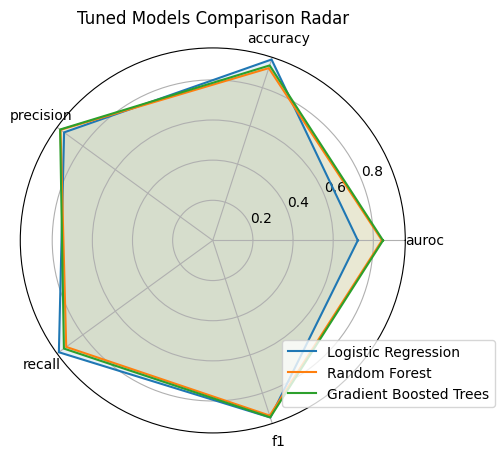

In [19]:
labels = tuned_metrics_df.columns
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))

for model in tuned_metrics_df.index:
    values = tuned_metrics_df.loc[model].tolist()
    values += values[:1]
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.1)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Tuned Models Comparison Radar")
ax.legend(loc="lower right", bbox_to_anchor=(1.25, 0.05))
plt.show()

In [20]:
# Only keep the three models in both DataFrames
basic_models = metrics_df.loc[["Random Forest", "Gradient Boosted Trees", "Logistic Regression"]].copy()
tuned_models = tuned_metrics_df.loc[["Random Forest", "Gradient Boosted Trees", "Logistic Regression"]].copy()

# Add a column to indicate type
basic_models["Type"] = "Basic"
tuned_models["Type"] = "Tuned"

# Combine
comparison_df = pd.concat([basic_models, tuned_models])
comparison_df


,auroc,accuracy,precision,recall,f1,Type
Random Forest,0.8307,0.8397,0.9388,0.8397,0.8789,Basic
Gradient Boosted Trees,0.8545,0.8606,0.9430,0.8606,0.8928,Basic
Logistic Regression,0.7291,0.9161,0.9193,0.9161,0.9177,Basic
Random Forest,0.8431,0.9027,0.9378,0.9027,0.9176,Tuned
Gradient Boosted Trees,0.8483,0.9169,0.9403,0.9169,0.9269,Tuned
Logistic Regression,0.7227,0.9479,0.9158,0.9479,0.9278,Tuned


### Basic Models VS Tuned Models Comparison:

Below we plot the difference in the metrics for the models in the basic models and after the hyperparameter tuning.

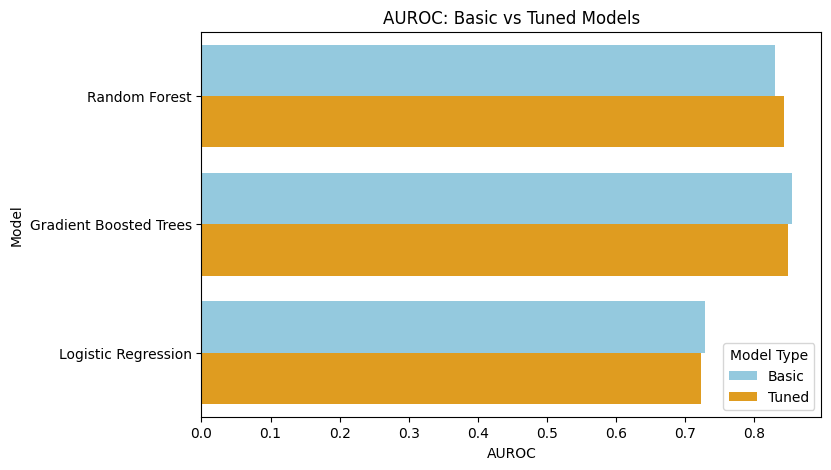

In [21]:
plt.figure(figsize=(8,5))
sns.barplot(
    x="auroc",
    y=comparison_df.index,
    hue="Type",
    data=comparison_df.reset_index(),
    palette=["skyblue","orange"]
)
plt.title("AUROC: Basic vs Tuned Models")
plt.xlabel("AUROC")
plt.ylabel("Model")
plt.legend(title="Model Type")
plt.show()


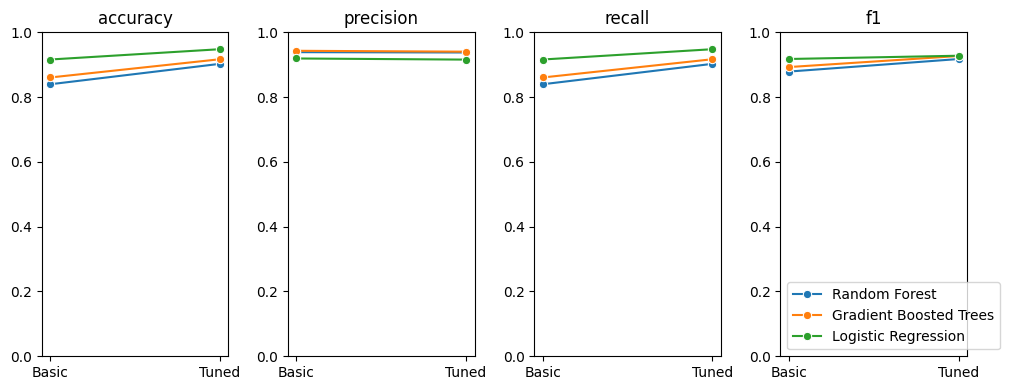

In [22]:
metrics_to_plot = ["accuracy","precision","recall","f1"]

comparison_df_reset = comparison_df.reset_index().melt(
    id_vars=["index","Type"],
    value_vars=metrics_to_plot,
    var_name="Metric",
    value_name="Score"
)

fig, axes = plt.subplots(1, 4, figsize=(10,4))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    data = comparison_df_reset[comparison_df_reset["Metric"] == metric]
    
    sns.lineplot(
        x="Type",        # Basic vs Tuned
        y="Score",
        hue="index",        # lines represent models
        marker="o",
        data=data,
        ax=ax,
        palette="tab10"
    )
    ax.legend_.remove()
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(metric)
    ax.set_ylim(0,1)

plt.tight_layout()
plt.legend()
plt.show()
